# 实验五

## 1. 文献学习
认真阅读文献《对冲基金分布复制模型的协方差估计与算法实现》第三节，学习协方差矩阵估计方法。

第三节的计算方法：

-  **基于因子模型的估计方法**  
    - 使用单因子市场模型（式16）：
    $$R_t^i = \alpha^i + \beta^i \cdot R_t^{\text{market}} + \epsilon_t^i$$
    其中，$\epsilon_t^i$为残差，协方差矩阵为：
    $$\Sigma_t^{(1)} = \sigma_{\text{market}}^2 \beta \beta' + \Delta$$

    - 通过偏差调整后的估计量（式18）：
    $$\hat{\Sigma}_t^{(1)} = \hat{\sigma}_m^2 \hat{\beta} \hat{\beta}' + \frac{T-2}{T-1} \tilde{\Delta}$$
    其中，$T$为时间长度，$\tilde{\Delta}$为调整后的残差协方差矩阵。

- **基于收缩模型的估计方法**  
    - 将样本协方差矩阵$\Sigma_t$与预定义的良态矩阵（如单位矩阵）线性组合（式19）：
    $$\hat{\Sigma}^{\text{shrink}} = (1 - \rho) \Sigma_t + \rho M$$
    收缩强度$\rho$通过式20计算：
    $$\rho = \min \left( \frac{(1 - \frac{2}{n}) \text{tr}(\Sigma_t^2) + (\text{tr}\Sigma_t)^2}{(T - \frac{2}{n}) \left( \text{tr}(\Sigma_t^2) - \frac{(\text{tr}\Sigma_t)^2}{n} \right)}, 1 \right)$$
   - 该方法通过收缩减少了样本协方差的估计误差，尤其适用于高维数据。

## 2. 数据处理与投资组合构建
下载10个行业2010-2021年的月度收益率数据，从2018年开始以这10个行业构建最优投资组合，并每月调整。计算所构建的最优投资组合从2018至2021年的超额收益。构建投资组合时，期望超额收益率为10个行业超额收益率历史均值的平均值。

### （1）协方差矩阵估计
构建投资组合除需要计算期望超额收益率外，还需要计算方差-协方差矩阵。请分别利用以下方法估计协方差矩阵，并展示2018年6月、2019年8月和2020年11月的计算结果：
- 样本方差-协方差矩阵
- 常量估计法
- 因子模型（Fama-French三因子模型）估计法
- 压缩估计法（压缩系数根据文献《对冲基金分布复制模型的协方差估计与算法实现》公式（20）计算）
- 指数加权移动平均估计法

### （2）最小化期望风险的最优权重
在最小化期望风险的条件下，计算最优权重。展示10个行业的最优投资权重的时间序列图，方差-协方差矩阵选取因子模型估计法计算结果。

### （3）最大化效用的最优权重
假设投资者的相对风险规避系数γ=3，全部投资于风险资产，在最大化效用的条件下，计算最优权重。展示10个行业的最优投资权重的时间序列图，方差-协方差矩阵选取压缩估计法计算结果。

### （4）样本外最优投资组合超额收益的描述性统计量
分别根据（2）和（3）的最优权重，计算样本外最优投资组合超额收益的描述性统计量，包括：
- 均值
- 标准差
- 夏普率

1. 数据处理

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare as ts
import scipy.optimize as sco
import seaborn as sns
import os

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
ts.set_token('2207b01a244311f7742512463d9e1588954d174b86d695f8a9f1cc4b')
pro = ts.pro_api()

In [3]:
def get_industry_data(save_path='./assets/data/industry_data.csv'):
    """
    获取10个行业指数的月度数据并保存到本地
    
    参数:
    save_path: 数据保存路径
    
    返回:
    all_data: DataFrame, 包含市场和行业收益率的数据
    excess_return_cols: list, 超额收益率列名
    industry_list: list, 行业代码列表
    """
    # 使用tushare获取行业指数数据
    # 这里使用申万一级行业指数
    industry_list = [
        '801010.SI',  # 农林牧渔
        '801020.SI',  # 采掘
        '801030.SI',  # 化工
        '801040.SI',  # 钢铁
        '801050.SI',  # 有色金属
        '801080.SI',  # 电子
        '801110.SI',  # 家用电器
        '801120.SI',  # 食品饮料
        '801180.SI',  # 房地产
        '801150.SI',  # 医药生物
    ]
    
    # 获取上证指数作为市场基准
    market_index = '000001.SH'
    
    # 设置时间范围
    start_date = '20100101'
    end_date = '20211231'
    
    # 获取市场指数数据
    market_data = pro.index_monthly(ts_code=market_index, 
                                  start_date=start_date,
                                  end_date=end_date,
                                  fields='ts_code,trade_date,close')
    market_data.sort_values('trade_date', inplace=True)
    market_data['market_return'] = market_data['close'].pct_change()

    print(market_data.head())
    
    # 获取行业指数数据
    industry_data = pd.DataFrame()
    for industry in industry_list:
        temp = pro.index_monthly(ts_code=industry, 
                               start_date=start_date,
                               end_date=end_date,
                               fields='ts_code,trade_date,close')
        temp.sort_values('trade_date', inplace=True)
        temp[f'{industry}_return'] = temp['close'].pct_change()
        
        if industry_data.empty:
            industry_data = temp[['trade_date', f'{industry}_return']]
        else:
            industry_data = pd.merge(industry_data, 
                                   temp[['trade_date', f'{industry}_return']], 
                                   on='trade_date', 
                                   how='outer')
    print(industry_data.head())
    
    # 合并市场和行业数据
    all_data = pd.merge(market_data[['trade_date', 'market_return']], 
                       industry_data, 
                       on='trade_date', 
                       how='outer')
    all_data.sort_values('trade_date', inplace=True)
    all_data.dropna(inplace=True)
    
    # 计算超额收益率 (行业收益率 - 市场收益率)
    excess_return_cols = []
    for industry in industry_list:
        col_name = f'{industry}_excess_return'
        all_data[col_name] = all_data[f'{industry}_return'] - all_data['market_return']
        excess_return_cols.append(col_name)
    
    # 添加时间索引便于后续处理
    all_data['date'] = pd.to_datetime(all_data['trade_date'])
    all_data.set_index('date', inplace=True)
    
    # 保存数据到本地
    try:
        all_data.to_csv(save_path)
        print(f"数据已保存至: {save_path}")
    except Exception as e:
        print(f"保存数据失败: {e}")
    
    return all_data, excess_return_cols, industry_list

In [4]:
def get_factors_data(filepath='./assets/data/fama.csv'):
    """
    加载本地Fama-French三因子数据
    
    参数:
    filepath: 三因子数据文件路径
    
    返回:
    factor_data: DataFrame, 三因子数据
    """
    # 读取本地CSV文件中的三因子数据
    factor_data = pd.read_csv(filepath)
    # 解析日期列为datetime类型并设置为索引
    factor_data['Date'] = pd.to_datetime(factor_data['日期_Date'])
    factor_data.set_index('Date', inplace=True)
    
    # 重命名列为标准名称
    factor_data.rename(columns={
        '市场溢酬因子__流通市值加权_Rmrf_tmv': 'MKT',
        '市值因子__流通市值加权_Smb_tmv': 'SMB',
        '账面市值比因子__流通市值加权_Hml_tmv': 'HML'
    }, inplace=True)
    
    # 转换为浮点数类型 (去除字符串中的引号)
    for col in ['MKT', 'SMB', 'HML']:
        if factor_data[col].dtype == 'object': 
            factor_data[col] = factor_data[col].str.replace('"', '').astype(float)
        elif pd.api.types.is_numeric_dtype(factor_data[col]):
            continue
        else:
            factor_data[col] = pd.to_numeric(factor_data[col], errors='coerce')
    
    print(f"成功加载三因子数据: {len(factor_data)}行")
    return factor_data

2. 方差-协方差矩阵计算

In [5]:
def sample_cov(returns, window=36):
    """
    计算样本方差-协方差矩阵
    
    参数:
    returns: DataFrame, 各资产的超额收益率
    window: int, 滚动窗口长度
    
    返回:
    cov_matrix: array, 方差-协方差矩阵
    """
    return returns.iloc[-window:].cov().values

In [6]:
def constant_cov(returns, window=36):
    """
    常量估计法计算协方差矩阵
    
    参数:
    returns: DataFrame, 各资产的超额收益率
    window: int, 滚动窗口长度
    
    返回:
    cov_matrix: array, 方差-协方差矩阵
    """
    # 提取样本数据
    sample_data = returns.iloc[-window:].values
    
    # 计算样本协方差矩阵
    sample_cov_matrix = np.cov(sample_data, rowvar=False)
    
    # 获取对角线元素(方差)
    var_diag = np.diag(sample_cov_matrix)
    
    # 计算平均方差
    avg_var = np.mean(var_diag)
    
    # 计算平均相关系数
    n = sample_cov_matrix.shape[0]
    sum_corr = 0
    count = 0
    
    for i in range(n):
        for j in range(i+1, n):
            if var_diag[i] > 0 and var_diag[j] > 0:
                corr = sample_cov_matrix[i, j] / np.sqrt(var_diag[i] * var_diag[j])
                sum_corr += corr
                count += 1
    
    avg_corr = sum_corr / count if count > 0 else 0
    
    # 构建常量协方差矩阵
    constant_matrix = np.zeros_like(sample_cov_matrix)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                constant_matrix[i, j] = var_diag[i]  # 保留原始方差
            else:
                constant_matrix[i, j] = avg_corr * np.sqrt(var_diag[i] * var_diag[j])
    
    return constant_matrix

In [7]:
def factor_model_cov(returns, factors, window=36):
    """
    使用Fama-French三因子模型估计协方差矩阵
    
    参数:
    returns: DataFrame, 各资产的超额收益率
    factors: DataFrame, 因子收益率 (应包含MKT, SMB, HML三个因子)
    window: int, 滚动窗口长度
    
    返回:
    cov_matrix: array, 方差-协方差矩阵
    """
    # 提取样本数据
    sample_returns = returns.iloc[-window:].values
    
    # 确保factors包含必要的三因子
    factor_cols = []
    if 'MKT' in factors.columns:
        factor_cols.append('MKT')
    if 'SMB' in factors.columns:
        factor_cols.append('SMB')
    if 'HML' in factors.columns:
        factor_cols.append('HML')
    
    if len(factor_cols) == 0:
        # 如果没有找到因子列，使用前三列作为替代
        factor_cols = factors.columns[:min(3, len(factors.columns))]
        print(f"警告：未找到标准三因子名称，使用 {factor_cols} 作为替代")
    
    sample_factors = factors[factor_cols].iloc[-window:].values
    
    # 构建设计矩阵 X (包含常数项和三因子)
    X = np.ones((len(sample_factors), 1 + len(factor_cols)))
    X[:, 1:] = sample_factors
    X = np.matrix(X)
    
    # 将收益率转换为矩阵
    Y = np.matrix(sample_returns)
    
    # 使用OLS估计系数
    # (X'X)^(-1)X'Y
    AB_hat = (X.T * X).I * (X.T * Y)
    
    # 提取alpha (常数项) 和 betas (因子载荷)
    ALPHA = AB_hat[0]
    BETAS = AB_hat[1:]
    
    # 计算残差
    RESD = Y - X * AB_hat
    
    # 计算因子协方差矩阵
    factor_cov = np.cov(sample_factors, rowvar=False)
    
    # 计算残差协方差 (只保留对角线元素)
    residual_cov = np.diag(np.diag(np.cov(RESD, rowvar=False)))
    
    # 偏差调整（论文中的公式18）
    T = window
    T_adjustment = (T - 2) / (T - 1)
    residual_cov_adjusted = T_adjustment * residual_cov
    
    # 计算总协方差矩阵 (公式18)
    # Σ = B * F * B' + Δ
    total_cov = BETAS.T * np.matrix(factor_cov) * BETAS + residual_cov_adjusted
    
    return np.array(total_cov)

In [8]:
def shrinkage_cov(returns, window=36):
    """
    使用压缩估计法计算协方差矩阵 (根据论文公式20)
    
    参数:
    returns: DataFrame, 各资产的超额收益率
    window: int, 滚动窗口长度
    
    返回:
    cov_matrix: array, 方差-协方差矩阵
    """
    # 提取样本数据
    sample_data = returns.iloc[-window:].values
    
    # 计算样本协方差矩阵
    sample_cov = np.cov(sample_data, rowvar=False)
    
    # 样本量和资产数
    T = window
    n = sample_cov.shape[0]
    
    # 计算目标矩阵 (这里使用对角矩阵作为目标)
    target_matrix = np.diag(np.diag(sample_cov))
    
    # 计算压缩强度 (根据论文中的公式20)
    trace_cov = np.trace(sample_cov)
    trace_cov_squared = np.trace(sample_cov @ sample_cov)
    
    # 计算分子
    numerator = (1 - 2/n) * trace_cov_squared + trace_cov**2
    
    # 计算分母
    denominator = (T - 2/n) * (trace_cov_squared - trace_cov**2/n)
    
    # 计算压缩系数
    shrinkage_intensity = min(numerator / denominator if denominator > 0 else 1, 1)
    
    # 应用压缩估计
    shrunk_cov = (1 - shrinkage_intensity) * sample_cov + shrinkage_intensity * target_matrix
    
    return shrunk_cov

In [9]:
def ewma_cov(returns, window=36, lambda_param=0.94):
    """
    使用指数加权移动平均法计算协方差矩阵
    
    参数:
    returns: DataFrame, 各资产的超额收益率
    window: int, 滚动窗口长度
    lambda_param: float, 衰减因子
    
    返回:
    cov_matrix: array, 方差-协方差矩阵
    """
    # 提取样本数据
    sample_data = returns.iloc[-window:].values
    n_assets = sample_data.shape[1]
    
    # 初始化EWMA协方差矩阵
    ewma_matrix = np.zeros((n_assets, n_assets))
    
    # 计算权重
    weights = np.array([(1-lambda_param) * lambda_param**i for i in range(window-1, -1, -1)])
    weights = weights / weights.sum()  # 归一化权重
    
    # 计算每对资产的协方差
    for i in range(n_assets):
        for j in range(i, n_assets):
            # 计算资产i和j的协方差
            cov_ij = np.sum(weights * sample_data[:, i] * sample_data[:, j])
            ewma_matrix[i, j] = cov_ij
            ewma_matrix[j, i] = cov_ij  # 确保矩阵对称
    
    return ewma_matrix

3. 最小化风险

In [10]:
def min_variance_portfolio(returns, cov_matrix, target_return=None):
    """
    计算最小方差投资组合权重
    
    参数:
    returns: array, 各资产的期望收益率
    cov_matrix: array, 方差-协方差矩阵
    target_return: float, 目标收益率(如果为None,则计算全局最小方差组合)
    
    返回:
    weights: array, 最优权重
    """
    n_assets = len(returns)
    
    # 转换为矩阵格式
    cov_matrix = np.matrix(cov_matrix)
    
    # 构建约束条件矩阵A和向量b
    # A包含收益率约束和权重和为1的约束
    mean_returns = np.mean(returns)
    
    # 如果指定了目标收益率，使用它；否则使用平均收益率
    up = target_return if target_return is not None else mean_returns
    
    # 构建A矩阵，第一行是收益率，第二行是1（权重和为1的约束）
    A = np.matrix(np.concatenate([returns[:, np.newaxis], np.ones((n_assets, 1))], axis=1)).T
    
    # 构建b向量
    b = np.matrix(np.array([up, 1])[:, np.newaxis])
    
    # 计算最优权重
    try:
        # 使用矩阵计算最优权重
        weights = cov_matrix.I * A.T * (A * cov_matrix.I * A.T).I * b
        return np.array(weights).flatten()
    except:
        # 如果矩阵求逆失败，回退到优化方法
        def portfolio_variance(weights):
            return weights @ cov_matrix @ weights
        
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
        if target_return is not None:
            constraints.append({'type': 'eq', 'fun': lambda x: np.sum(x * returns) - target_return})
        
        bounds = tuple((0, 1) for _ in range(n_assets))
        initial_weights = np.ones(n_assets) / n_assets
        
        result = sco.minimize(
            portfolio_variance,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        return result['x']

4. 最大化效用

In [11]:
def max_utility_portfolio(returns, cov_matrix, risk_aversion=3):
    """
    计算最大化效用的投资组合权重 (根据课堂示例)
    
    参数:
    returns: array, 各资产的期望收益率
    cov_matrix: array, 方差-协方差矩阵
    risk_aversion: float, 风险厌恶系数
    
    返回:
    weights: array, 最优权重
    """
    n_assets = len(returns)
    
    # 转换为矩阵格式
    returns = np.array(returns)
    cov_matrix = np.matrix(cov_matrix)
    
    # 定义效用函数: U = μ'w - (γ/2) * w'Σw
    # 最大化效用等价于最小化负效用
    # 在矩阵求解中，对于给定的γ，最优投资组合权重为：
    # w* = (1/γ) * Σ^-1 * μ
    # 但需要调整确保权重和为1
    
    try:
        # 首先计算无约束解
        w_unconstrained = (1 / risk_aversion) * cov_matrix.I * np.matrix(returns).T
        
        # 添加约束条件，权重和为1
        ones = np.ones(n_assets)
        ones_matrix = np.matrix(ones).T
        
        # 计算拉格朗日乘子
        lambda_multiplier = (1 - ones.T @ w_unconstrained) / (ones.T @ cov_matrix.I @ ones_matrix)
        
        # 计算最终的最优权重
        w_star = w_unconstrained + lambda_multiplier[0, 0] * (cov_matrix.I @ ones_matrix)
        
        # 转换为数组并返回
        return np.array(w_star).flatten()
    except:
        # 如果矩阵求逆失败，回退到优化方法
        def negative_utility(weights):
            portfolio_return = np.sum(weights * returns)
            portfolio_variance = weights @ cov_matrix @ weights
            utility = portfolio_return - 0.5 * risk_aversion * portfolio_variance
            return -utility  # 最小化负效用等于最大化效用
        
        constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # 权重和为1
        bounds = tuple((0, 1) for _ in range(n_assets))  # 权重范围在0和1之间
        initial_weights = np.ones(n_assets) / n_assets  # 初始权重平均分配
        
        result = sco.minimize(
            negative_utility,
            initial_weights,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        return result['x']

5. 走一遍流程

In [12]:
all_data, excess_return_cols, industry_list = get_industry_data()

       ts_code trade_date     close  market_return
143  000001.SH   20100129  2989.292            NaN
142  000001.SH   20100226  3051.943       0.020958
141  000001.SH   20100331  3109.105       0.018730
140  000001.SH   20100430  2870.611      -0.076708
139  000001.SH   20100531  2592.147      -0.097005
  trade_date  801010.SI_return  801020.SI_return  801030.SI_return  \
0   20100129               NaN               NaN               NaN   
1   20100226          0.054782          0.007282          0.014999   
2   20100331         -0.012447          0.036284          0.032012   
3   20100430         -0.033861         -0.031127         -0.113221   
4   20100531         -0.054705         -0.117694         -0.116429   

   801040.SI_return  801050.SI_return  801080.SI_return  801110.SI_return  \
0               NaN               NaN               NaN               NaN   
1          0.035771          0.027310          0.041176          0.073851   
2         -0.016291          0.023829     

In [13]:
factor_data = get_factors_data()

成功加载三因子数据: 1296行


In [14]:
start_date = '2018-01-01'
end_date = '2021-12-31'
window = 36  # 使用3年数据估计协方差矩阵

In [15]:
 # 提取回测期间的数据
backtest_data = all_data[all_data.index >= start_date].copy()

In [16]:
# 创建DataFrame存储不同协方差估计方法下的最优权重和收益率
weights_min_var = pd.DataFrame(index=backtest_data.index, columns=excess_return_cols)
weights_max_util = pd.DataFrame(index=backtest_data.index, columns=excess_return_cols)

# 创建字典存储不同协方差估计方法下的计算结果
cov_matrices = {
    'sample': {},
    'constant': {},
    'factor': {},
    'shrinkage': {},
    'ewma': {}
}

# 指定展示结果的日期
showcase_dates = [
    pd.Timestamp('2018-06-30'),
    pd.Timestamp('2019-08-31'),
    pd.Timestamp('2020-11-30')
]

# 保存所有月份的协方差矩阵，用于后续分析
all_cov_matrices = {
    'sample': {},
    'constant': {},
    'factor': {},
    'shrinkage': {},
    'ewma': {}
}

In [17]:
# 投资组合回测
for i, current_date in enumerate(backtest_data.index):
    print(f"计算日期: {current_date.strftime('%Y-%m-%d')}")
    
    # 提取当前日期之前的数据用于估计
    historical_data = all_data.loc[:current_date].copy()
    
    # 检查是否有足够的历史数据
    if len(historical_data) < window:
        print(f"警告: {current_date} 历史数据不足 {window} 个月，跳过")
        continue
    
    # 提取超额收益率数据 - 使用最近的window个月
    excess_returns = historical_data[excess_return_cols].iloc[-window:]
    
    # 计算期望超额收益率 (使用历史平均值)
    expected_returns = excess_returns.iloc[-window:].mean().values
    
    # 为所有行业设置相同的期望超额收益率 (按照题目要求)
    avg_expected_return = np.mean(expected_returns)
    expected_returns = np.ones_like(expected_returns) * avg_expected_return
    
    ### 1. 估计协方差矩阵
    try:
        # 样本协方差矩阵
        cov_sample = sample_cov(excess_returns, window)
        
        # 常量估计法
        cov_constant = constant_cov(excess_returns, window)
        
        # 因子模型估计法
        # 确保因子数据和收益率数据日期匹配
        factor_returns = factor_data[factor_data.index <= current_date]
        factor_returns = factor_returns.iloc[-window:] if len(factor_returns) >= window else factor_returns
        if len(factor_returns) < window:
            print(f"警告: 因子数据不足 {window} 个月, 仅使用 {len(factor_returns)} 个月")
        
        # 单因子模型（市场因子）
        cov_factor = factor_model_cov(excess_returns, factor_returns, min(window, len(factor_returns)))
        
        # 压缩估计法 (使用样本协方差和因子模型协方差的结合)
        # 使用固定的压缩系数0.5
        cov_shrinkage = shrinkage_cov(excess_returns, window)
        
        # 指数加权移动平均法
        cov_ewma = ewma_cov(excess_returns, window)
        
        # 保存所有月份的协方差矩阵
        date_str = current_date.strftime('%Y-%m-%d')
        all_cov_matrices['sample'][date_str] = cov_sample
        all_cov_matrices['constant'][date_str] = cov_constant
        all_cov_matrices['factor'][date_str] = cov_factor
        all_cov_matrices['shrinkage'][date_str] = cov_shrinkage
        all_cov_matrices['ewma'][date_str] = cov_ewma
        
        # 保存指定展示日期的协方差矩阵
        if current_date in showcase_dates:
            cov_matrices['sample'][date_str] = cov_sample
            cov_matrices['constant'][date_str] = cov_constant
            cov_matrices['factor'][date_str] = cov_factor
            cov_matrices['shrinkage'][date_str] = cov_shrinkage
            cov_matrices['ewma'][date_str] = cov_ewma
        
        ### 2. 计算最优权重
        
        # 最小化期望风险的权重 (使用因子模型估计的协方差矩阵)
        weights_min_var.loc[current_date] = min_variance_portfolio(
            expected_returns, cov_factor, avg_expected_return)
        
        # 最大化效用的权重 (使用压缩估计法计算的协方差矩阵)
        weights_max_util.loc[current_date] = max_utility_portfolio(
            expected_returns, cov_shrinkage, risk_aversion=3)
            
    except Exception as e:
        print(f"计算日期 {date_str} 出错: {e}")
        continue

计算日期: 2018-01-31
计算日期: 2018-02-28
计算日期: 2018-03-30
计算日期: 2018-04-27
计算日期: 2018-05-31
计算日期: 2018-06-29
计算日期: 2018-07-31
计算日期: 2018-08-31
计算日期: 2018-09-28
计算日期: 2018-10-31
计算日期: 2018-11-30
计算日期: 2018-12-28
计算日期: 2019-01-31
计算日期: 2019-02-28
计算日期: 2019-03-29
计算日期: 2019-04-30
计算日期: 2019-05-31
计算日期: 2019-06-28
计算日期: 2019-07-31
计算日期: 2019-08-30
计算日期: 2019-09-30
计算日期: 2019-10-31
计算日期: 2019-11-29
计算日期: 2019-12-31
计算日期: 2020-01-23
计算日期: 2020-02-28
计算日期: 2020-03-31
计算日期: 2020-04-30
计算日期: 2020-05-29
计算日期: 2020-06-30
计算日期: 2020-07-31
计算日期: 2020-08-31
计算日期: 2020-09-30
计算日期: 2020-10-30
计算日期: 2020-11-30
计算日期: 2020-12-31
计算日期: 2021-01-29
计算日期: 2021-02-26
计算日期: 2021-03-31
计算日期: 2021-04-30
计算日期: 2021-05-31
计算日期: 2021-06-30
计算日期: 2021-07-30
计算日期: 2021-08-31
计算日期: 2021-09-30
计算日期: 2021-10-29
计算日期: 2021-11-30
计算日期: 2021-12-31


In [18]:
# 计算投资组合收益率
portfolio_returns_min_var = pd.Series(index=weights_min_var.index)
portfolio_returns_max_util = pd.Series(index=weights_max_util.index)

for date in weights_min_var.index:
    if date < backtest_data.index[-1]:
        # 获取下一期的日期
        next_dates = backtest_data.index[backtest_data.index > date]
        if len(next_dates) > 0:
            next_date = next_dates[0]
            
            # 提取下一期的超额收益率
            next_returns = backtest_data.loc[next_date, excess_return_cols].values
            
            # 计算投资组合收益率
            if date in weights_min_var.index and not weights_min_var.loc[date].isna().all():
                portfolio_returns_min_var[date] = np.sum(weights_min_var.loc[date].values * next_returns)
            
            if date in weights_max_util.index and not weights_max_util.loc[date].isna().all():
                portfolio_returns_max_util[date] = np.sum(weights_max_util.loc[date].values * next_returns)

In [19]:
# 保存协方差矩阵和权重结果到CSV
save_results = True
if save_results:
    # 创建结果目录
    os.makedirs('./assets/results', exist_ok=True)
    
    # 保存最优权重
    weights_min_var.to_csv('./assets/results/weights_min_var.csv')
    weights_max_util.to_csv('./assets/results/weights_max_util.csv')
    
    # 保存投资组合收益率
    portfolio_returns_min_var.to_csv('./assets/results/portfolio_returns_min_var.csv')
    portfolio_returns_max_util.to_csv('./assets/results/portfolio_returns_max_util.csv')
    
    # 保存指定日期的协方差矩阵结果
    for method in cov_matrices:
        for date in cov_matrices[method]:
            pd.DataFrame(cov_matrices[method][date]).to_csv(f'./assets/results/cov_{method}_{date}.csv')

6. 可视化

In [20]:
def plot_weights(weights_df, title, industry_names):
    """
    绘制投资组合权重的时间序列图
    
    参数:
    weights_df: DataFrame, 包含各资产权重的时间序列数据
    title: str, 图表标题
    industry_names: list, 行业名称列表
    """
    plt.figure(figsize=(15, 8))
    
    # 清理数据 - 移除全为NaN的行
    weights_df_clean = weights_df.dropna(how='all')
    
    # 如果数据为空，则返回
    if weights_df_clean.empty:
        print(f"警告: 权重数据为空，无法绘图")
        return
    
    # 打印权重数据的基本信息
    print(f"权重数据信息:")
    print(f"- 时间范围: {weights_df_clean.index.min()} 至 {weights_df_clean.index.max()}")
    print(f"- 数据点数量: {len(weights_df_clean)}")
    print(f"- NaN值数量: {weights_df_clean.isna().sum().sum()}")
    
    # 将行业代码映射到行业名称
    columns = weights_df_clean.columns
    weights_df_renamed = weights_df_clean.copy()
    weights_df_renamed.columns = [f"{i+1}.{ind.split('.')[0]}" for i, ind in enumerate(industry_names)]
    
    # 绘制
    weights_df_renamed.plot(kind='line', alpha=0.7, figsize=(15, 8))
    
    plt.title(title, fontsize=15)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('权重', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

权重数据信息:
- 时间范围: 2018-01-31 00:00:00 至 2021-12-31 00:00:00
- 数据点数量: 48
- NaN值数量: 0


<Figure size 1500x800 with 0 Axes>

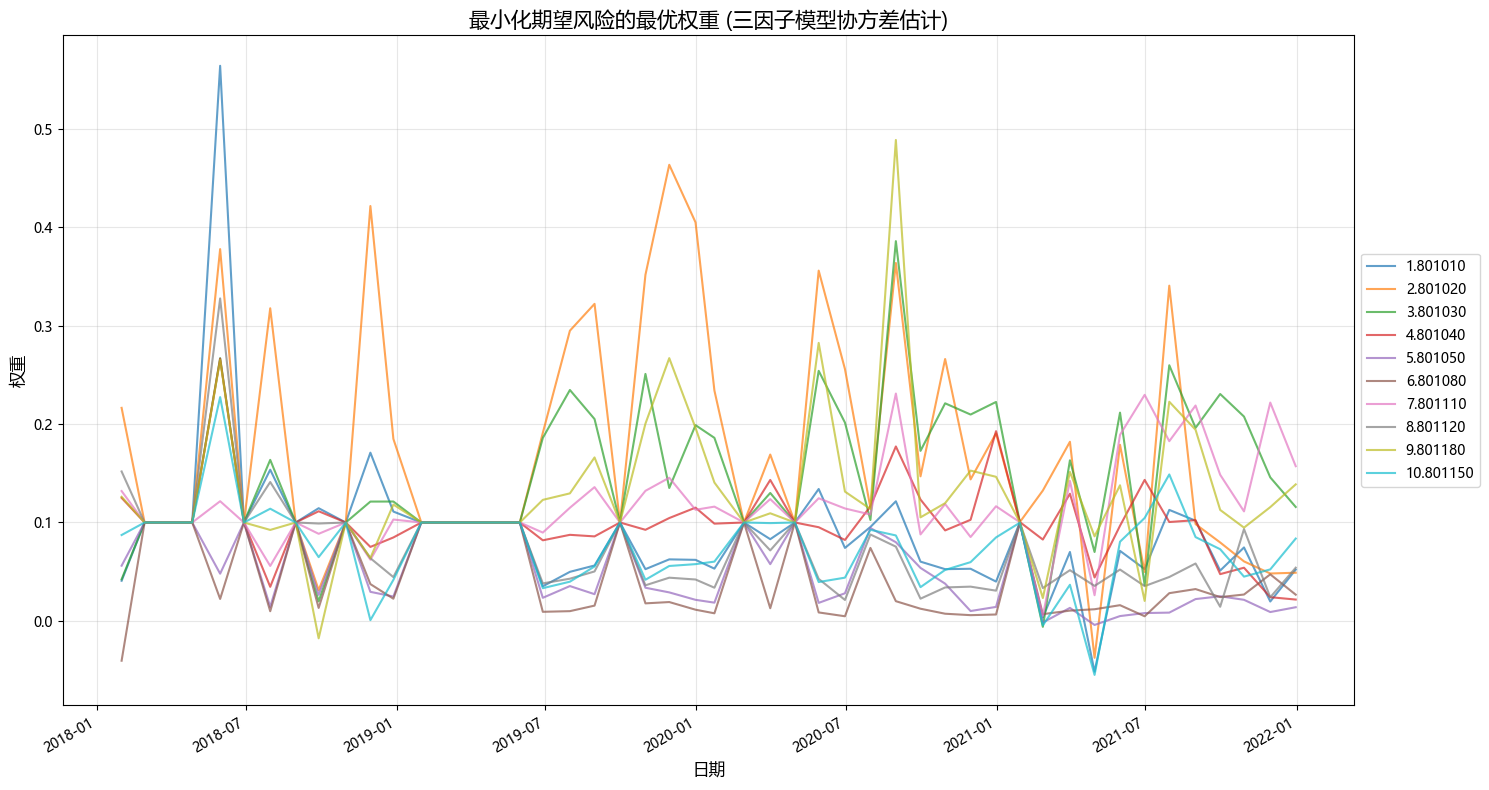

权重数据信息:
- 时间范围: 2018-01-31 00:00:00 至 2021-12-31 00:00:00
- 数据点数量: 48
- NaN值数量: 0


<Figure size 1500x800 with 0 Axes>

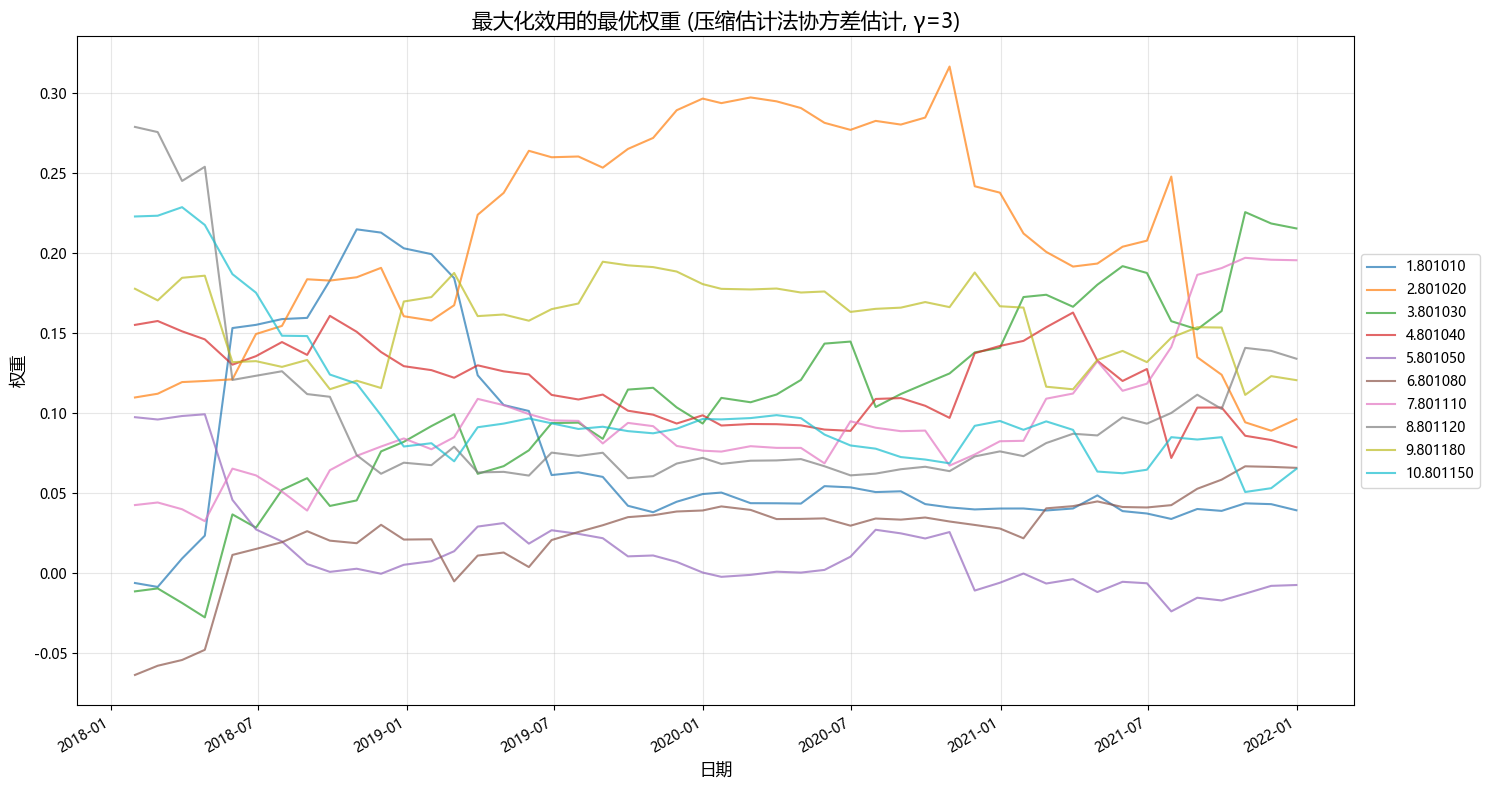

In [21]:
# 1. 绘制最优权重的时间序列图

# 绘制最小方差组合的权重
plot_weights(weights_min_var, '最小化期望风险的最优权重 (三因子模型协方差估计)', industry_list)
plt.show()

# 绘制最大化效用组合的权重
plot_weights(weights_max_util, '最大化效用的最优权重 (压缩估计法协方差估计, γ=3)', industry_list)
plt.show()

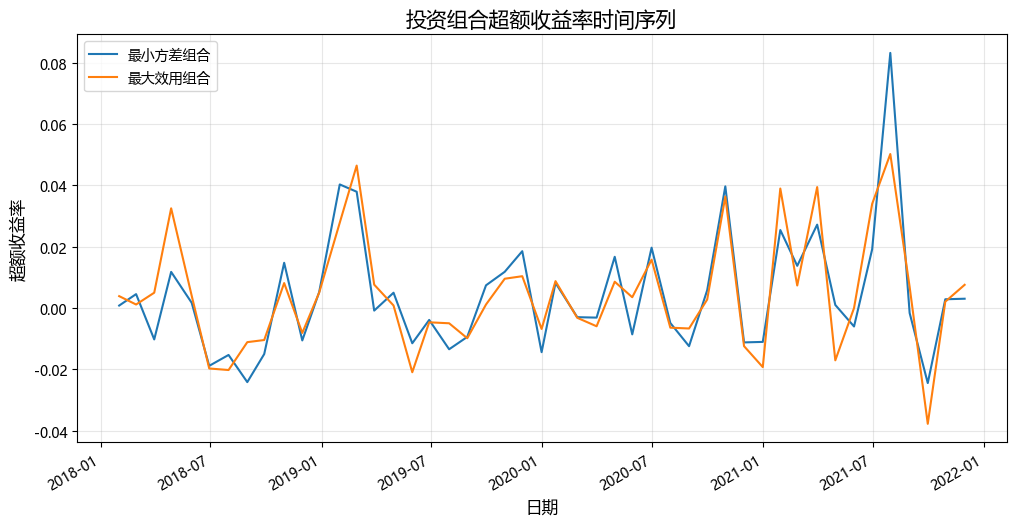

In [22]:
# 2. 绘制投资组合收益率时间序列图
plt.figure(figsize=(12, 6))
portfolio_returns_min_var.plot(label='最小方差组合')
portfolio_returns_max_util.plot(label='最大效用组合')
plt.title('投资组合超额收益率时间序列', fontsize=15)
plt.xlabel('日期', fontsize=12)
plt.ylabel('超额收益率', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
def calculate_portfolio_stats(returns):
    """
    计算投资组合的描述性统计量
    
    参数:
    returns: Series, 投资组合收益率时间序列
    
    返回:
    stats: dict, 包含均值、标准差和夏普比率的字典
    """
    if returns.empty:
        print("警告: 收益率数据为空")
        return {
            '年化收益率': 0,
            '年化波动率': 0,
            '夏普比率': 0
        }
    
    # 打印收益率数据的基本信息
    print(f"收益率数据信息:")
    print(f"- 时间范围: {returns.index.min()} 至 {returns.index.max()}")
    print(f"- 数据点数量: {len(returns)}")
    print(f"- NaN值数量: {returns.isna().sum()}")
    
    # 清理数据
    returns_clean = returns.dropna()
    
    # 计算年化收益率 (假设月度数据)
    annual_return = returns_clean.mean() * 12
    
    # 计算年化波动率
    annual_volatility = returns_clean.std() * np.sqrt(12)
    
    # 计算夏普比率 (假设无风险利率为0)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0
    
    # 返回统计结果
    stats = {
        '年化收益率': annual_return,
        '年化波动率': annual_volatility,
        '夏普比率': sharpe_ratio
    }
    
    return stats

In [24]:
# 3. 计算并展示投资组合统计量
min_var_stats = calculate_portfolio_stats(portfolio_returns_min_var.dropna())
max_util_stats = calculate_portfolio_stats(portfolio_returns_max_util.dropna())

stats_df = pd.DataFrame({
    '最小化期望风险组合': min_var_stats,
    '最大化效用组合': max_util_stats
})

print("\n投资组合超额收益的描述性统计量:")
print(stats_df)

收益率数据信息:
- 时间范围: 2018-01-31 00:00:00 至 2021-11-30 00:00:00
- 数据点数量: 47
- NaN值数量: 0
收益率数据信息:
- 时间范围: 2018-01-31 00:00:00 至 2021-11-30 00:00:00
- 数据点数量: 47
- NaN值数量: 0

投资组合超额收益的描述性统计量:
       最小化期望风险组合   最大化效用组合
年化收益率   0.048926  0.051141
年化波动率   0.068291  0.065209
夏普比率    0.716432  0.784266


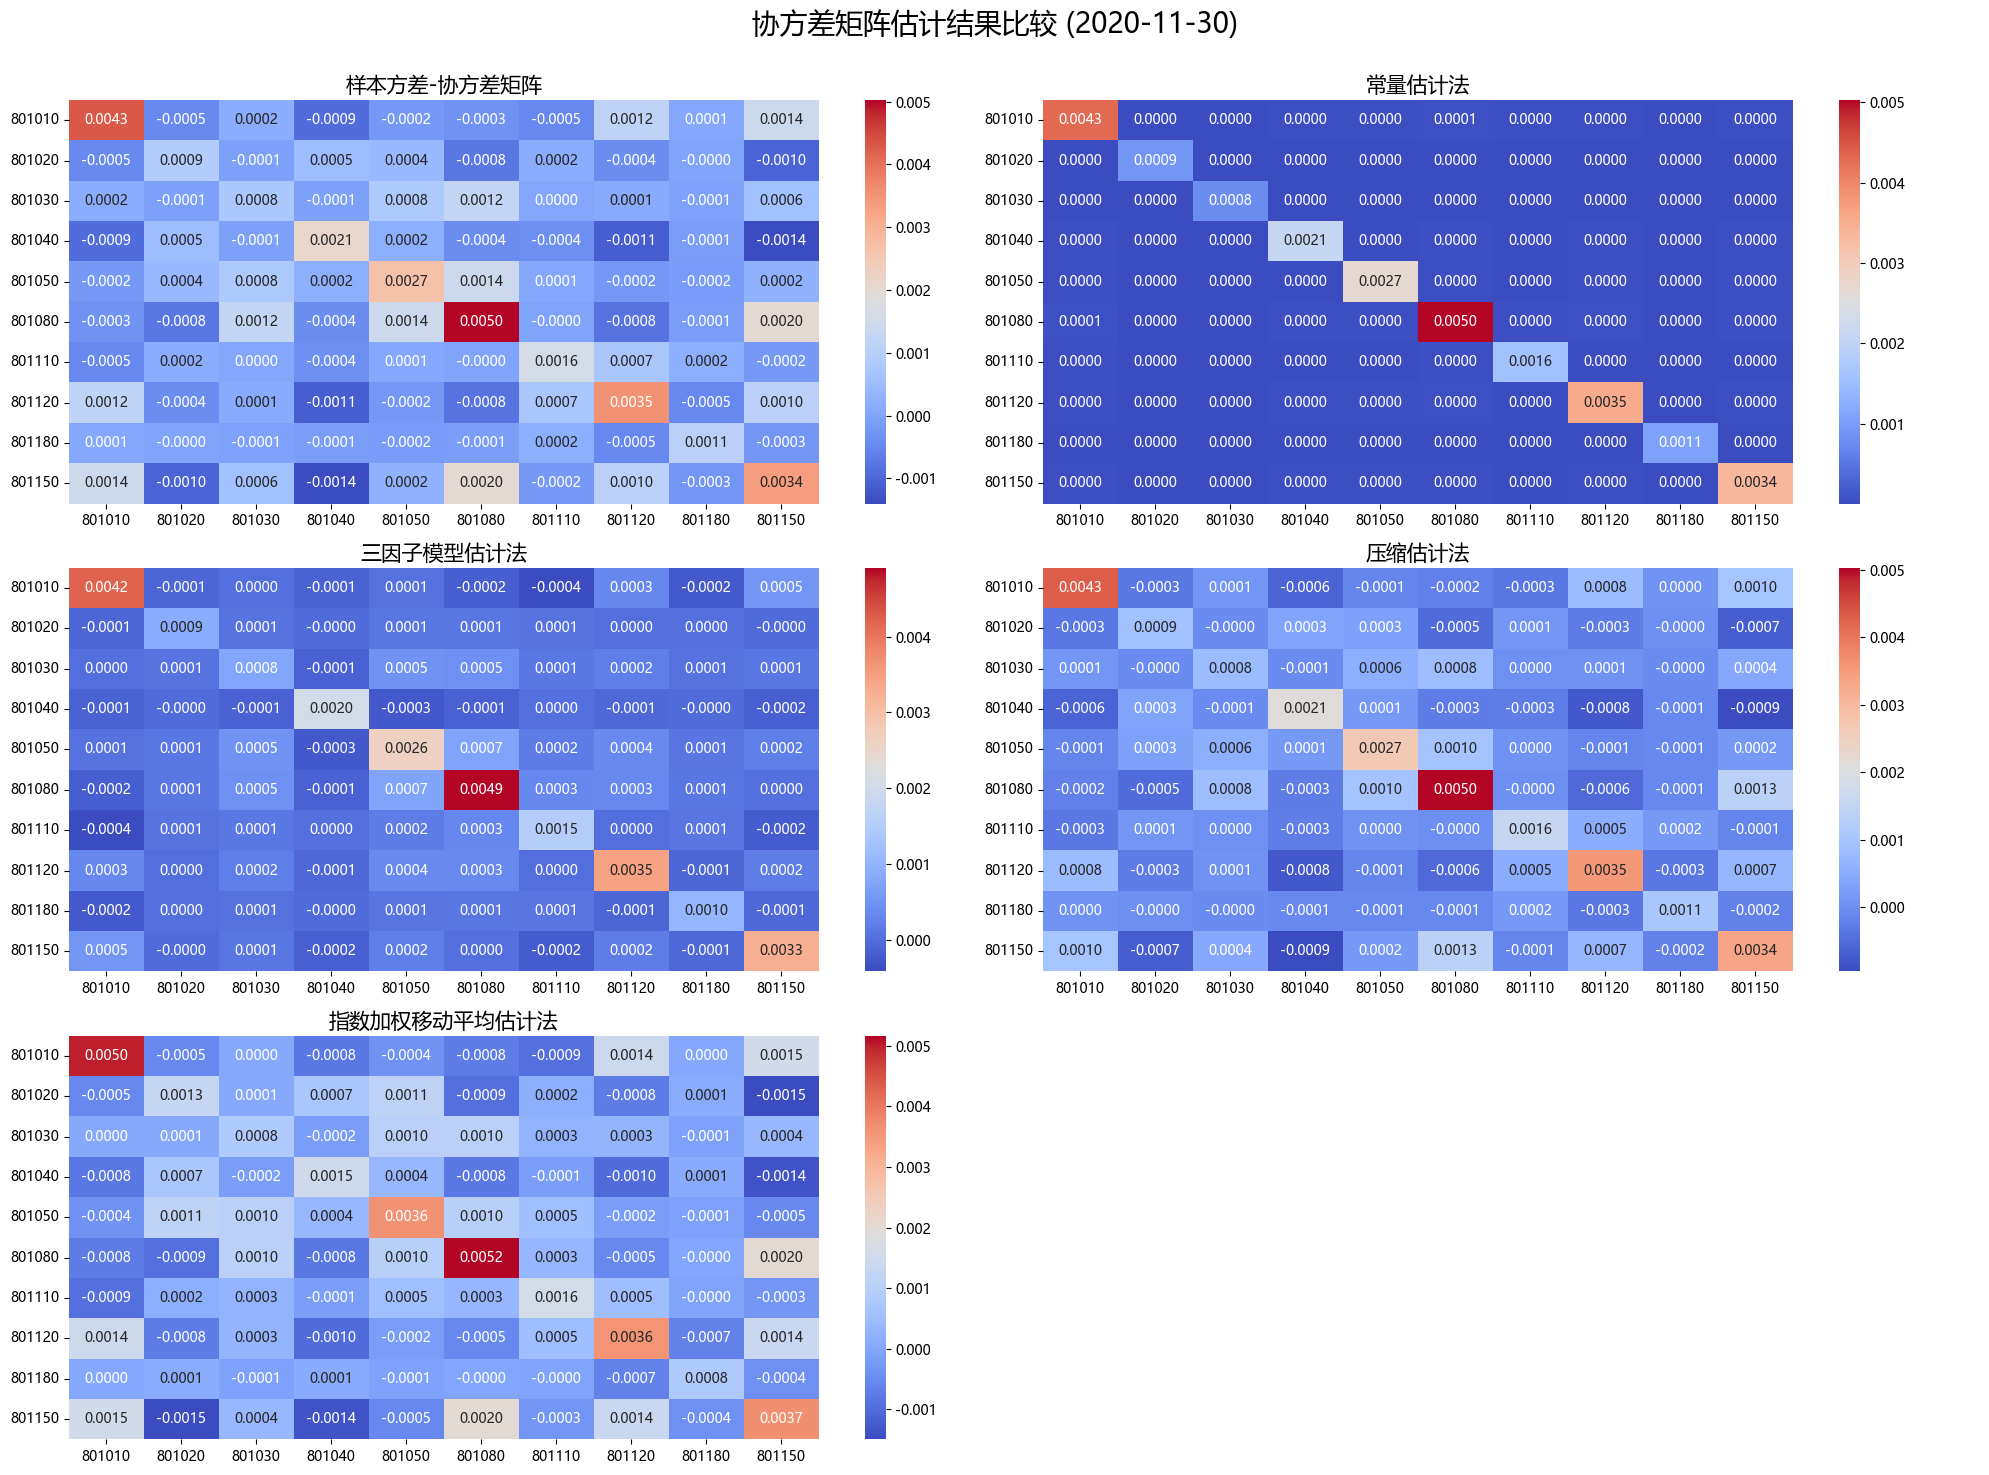

In [25]:
# 4. 可视化协方差矩阵估计结果（展示指定日期）
# 行业简称，用于图表展示
industry_short_names = [ind.split('.')[0] for ind in industry_list]

# 为每个指定日期创建协方差矩阵对比图
for date in showcase_dates:
    date_str = date.strftime('%Y-%m-%d')
    if date_str in cov_matrices['sample']:
        # 创建一个包含所有方法的大图
        fig, axes = plt.subplots(3, 2, figsize=(20, 15))
        fig.suptitle(f'协方差矩阵估计结果比较 ({date_str})', fontsize=20)
        
        # 扁平化axes数组以方便索引
        axes = axes.flatten()
        
        # 绘制各种方法的协方差矩阵热图
        for i, (method, method_name) in enumerate([
            ('sample', '样本方差-协方差矩阵'),
            ('constant', '常量估计法'),
            ('factor', '三因子模型估计法'),
            ('shrinkage', '压缩估计法'),
            ('ewma', '指数加权移动平均估计法')
        ]):
            if date_str in cov_matrices[method]:
                sns.heatmap(cov_matrices[method][date_str], 
                       annot=True, 
                       fmt='.4f', 
                       cmap='coolwarm',
                       xticklabels=industry_short_names,
                       yticklabels=industry_short_names,
                       ax=axes[i])
                axes[i].set_title(method_name, fontsize=15)
        
        # 隐藏未使用的子图
        if len(axes) > 5:
            axes[5].axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()